# Compare Hankel and Fourier Transforms

This will compare the forward and inverse transforms for both Hankel and Fourier by either computing partial derivatives of solving a parital differential equation.

This notebook focuses on the Laplacian operator in the case of radial symmetry. 

Consider two 2D circularly-symmetric functions $f(r)$ and $g(r)$ that are related by the following differential operator,

$$
g(r) = \nabla^2 f(r) 
= \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial f}{\partial r} \right)
$$

In this notebook we will consider two problems:
1. Given $f(r)$, compute the Laplacian to obtain $g(r)$
2. Given $g(r)$, invert the Laplacian to obtain $f(r)$

We can use the 1D Hankel (or 2D Fourier) transform to compute the Laplacian in three steps:
1. Compute the Forward Transform
    $$
    \mathcal{H}[f(r)] = \hat f(k)
    $$
2. Differentiate in Spectral space
    $$
    \hat g(k) = - k^2 \hat f(k)
    $$
3. Compute the Inverse Transform
    $$
    g(r) = \mathcal{H}^{-1} [\hat g(k)]
    $$
    
This is easily done in two-dimensions using the Fast Fourier Transform (FFT) but one advantage of the Hankel transform is that we only have a one-dimensional transform.

In particular, we will use the function

$$
f(r) = e^{-r^2},
$$

and, though it is arbitrary, we will use the Fourier convention that $(a, b)=(1,1)$. This gives the corollary functions

\begin{align}
    \hat{f}(k) &= \pi e^{-k^2/4} \\
    \hat{g}(k) &= -k^2 \pi e^{-k^2/4} \\ 
    g(r) &= 4 e^{-r^2} (r^2 - 1) \\
\end{align}

## Setup

### Import Relevant Libraries

In [1]:
# Import Libraries

import numpy as np                                                        # Numpy
from powerbox import dft                                                  # powerbox for DFTs (v0.6.0+)
from hankel import SymmetricFourierTransform                              # Hankel
from scipy.interpolate import InterpolatedUnivariateSpline as spline      # Splines
import matplotlib.pyplot as plt                                           # Plotting
%matplotlib inline

import hankel
print("Using hankel v{}".format(hankel.__version__))

Using hankel v0.3.8


### Define Sample Functions

In [2]:
f = lambda r: np.exp(-r**2)
g = lambda r: 4.0*np.exp(-r**2)*(r**2 - 1.0)
fhat = lambda k : np.pi * np.exp(-k**2/4)
ghat = lambda k : -k**2 * np.pi * np.exp(-k**2/4)

### Define Transformation Functions

In [3]:
def ft2d(X, L, inverse=False):
    """Convenience function for getting Fourier Transform and average in annular bins"""
    if inverse:
        ft, _, xgrid = dft.ifft(X, L=L, a=1, b=1, ret_cubegrid=True)
    else:
        ft, _, xgrid = dft.fft(X, L=L, a=1, b=1, ret_cubegrid=True)
            
    # Get a sorted array of the transform
    ind = np.argsort(xgrid.flatten())
    _xgrid = xgrid.flatten()[ind]
    _ft = ft.flatten()[ind]
    
    # Just take unique values.
    _xgrid, ind = np.unique(_xgrid, return_index=True)
    _ft = _ft[ind]
    
    return ft, xgrid, _xgrid, _ft.real # we only deal with real functions here.

### Grid Setup

In [4]:
L     = 10.0    # Size of box for transform
N     = 128     # Grid size
b0    = 1.0

In [35]:
dr = L/N

# Create persistent dictionaries to track Hankel and Fourier results throughout.
H = {} # Hankel dict
F = {} # Fourier dict

r = np.linspace(dr/2, L-dr/2, N)

# 1D Grid for Hankel
H['r'] = r
H['k'] = np.logspace(-0.4, 4, 2*N)      # k-space is rather arbitrary.

# 2D Grid for Fourier
F['x'] = np.arange(-N, N)*dr
F['rgrid'] = np.sqrt(np.add.outer(F['x']**2, F['x']**2))
F['fgrid'] = f(F['rgrid'])

### Analytic Result

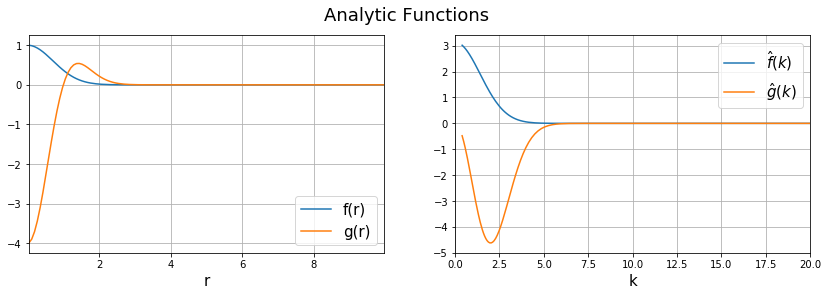

In [36]:
fig, ax = plt.subplots(1,2, gridspec_kw={"hspace":0.05}, figsize=(14, 4))

ax[0].plot(r, f(r), label="f(r)")
ax[0].plot(r, g(r), label='g(r)')
ax[0].set_xlim(r.min(), r.max())
plt.suptitle('Analytic Functions', fontsize=18)
ax[0].legend(loc='best', fontsize=15);
ax[0].set_xlabel("r", fontsize=15)

ax[1].plot(H['k'], fhat(H['k']), label="$\hat{f}(k)$")
ax[1].plot(H['k'], ghat(H['k']), label="$\hat{g}(k)$")
ax[1].legend(loc='best', fontsize=15)
ax[1].set_xlabel('k', fontsize=15)
ax[1].set_xlim(0, 20)

ax[0].grid(True)
ax[1].grid(True)

### Utility Functions

In [37]:
def plot_comparison(x, y, ylabel, comp_ylim=None, **subplot_kw):
    fnc = globals()[y]
    
    subplot_kw.update({"xscale":'log'})
    
    fig, ax = plt.subplots(
        2,1, sharex=True, subplot_kw=subplot_kw, 
        figsize=(12, 7), gridspec_kw={"hspace":0.07})

    ax[0].plot(H[x], fnc(H[x]), linewidth=2, label="Analytic", color="C2")
    ax[0].plot(H[x], H[y],linewidth=2, ls="--", label="Hankel")
    ax[0].plot(F[x], F[y],linewidth=2, ls="--", label="Fourier")
    
    ax[0].legend(fontsize=14)
    ax[0].grid(True)
    ax[0].set_ylabel(ylabel, fontsize=15)

    ax[1].plot(H[x], np.abs(H[y] - fnc(H[x])))
    ax[1].plot(F[x], np.abs(F[y] - fnc(F[x])))
    ax[1].grid(True)
    ax[1].set_ylabel("Residual", fontsize=15)
    ax[1].set_xlabel(x, fontsize=15)
    ax[1].set_yscale('log')
        
    if comp_ylim:
        ax[1].set_ylim(comp_ylim)

## Example 1: Compute Laplacian

### 1. Forward Transform

#### a. Hankel

In [38]:
# Compute Hankel transform

ht = SymmetricFourierTransform(ndim=2, h=0.0005)      # Create the Hankel Transform class
H['fhat'] = ht.transform(f, H['k'], ret_err=False)        # Return the transform of f at k.

#### b. Fourier

In [39]:
F['fhat_grid'], F['kgrid'], F['k'], F['fhat'] = ft2d(F['fgrid'], 2*L)

#### c. Comparison

Comparing the results of the Hankel and Fourier Transforms, we have

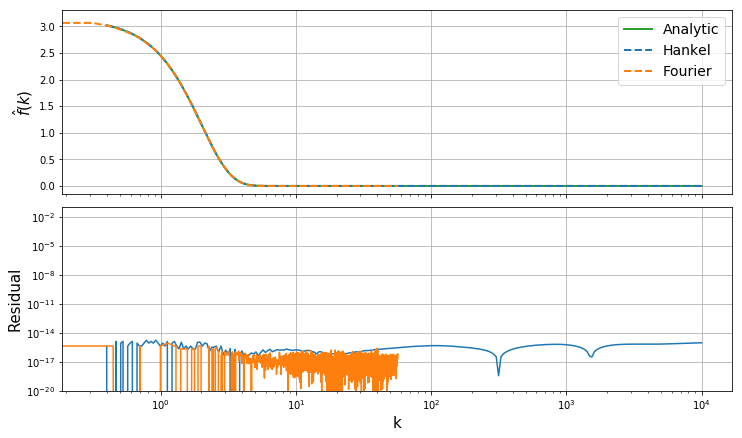

In [40]:
plot_comparison('k', 'fhat', "$\hat{f}(k)$", comp_ylim=(1e-20, 1e-1))

### 2. Inverse Transform

#### a. Hankel

In [41]:
# Build a spline to approximate ghat

H['ghat'] =  -H['k']**2 * H['fhat']
spl = spline(H['k'], H['ghat'])

# Do the transform
H['g'] = ht.transform(spl, H['r'], ret_err=False, inverse=True)

#### b. Fourier

In [42]:
F['ghat'] =  -F['kgrid']**2 *F['fhat_grid']
F['ggrid'], _, F['r'], F['g'] = ft2d(F['ghat'], 2*L, inverse=True)

#### c. Compare

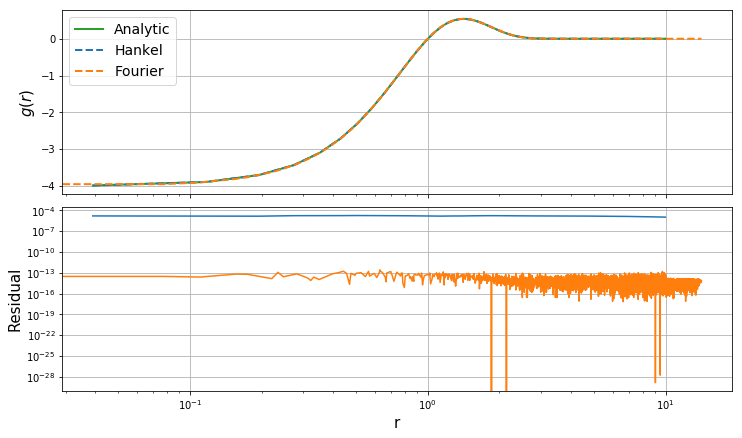

In [43]:
plot_comparison('r', 'g', "$g(r)$")

## Example 2: Invert Laplacian

We use the 1D Hankel (or 2D Fourier) transform to compute the Laplacian in three steps:
1. Compute the Forward Transform
    $$
    \mathcal{H}[g(r)] = \hat g(k)
    $$
2. Differentiate in Spectral space
    $$
    \hat f(k) = - \frac{1}{k^2} \hat g(k)
    $$
3. Compute the Inverse Transform
    $$
    f(r) = \mathcal{H}^{-1} [\hat f(k)]
    $$

### 1. Forward Transform

#### a. Hankel

In [44]:
H['ghat'] = ht.transform(g, H['k'], ret_err=False)        # Return the transform of g at k.

#### b. Fourier

In [45]:
# Compute Fourier Transform

F['ghat_grid'], _, _, F['ghat'] = ft2d(g(F['rgrid']), 2*L)

#### c. Compare

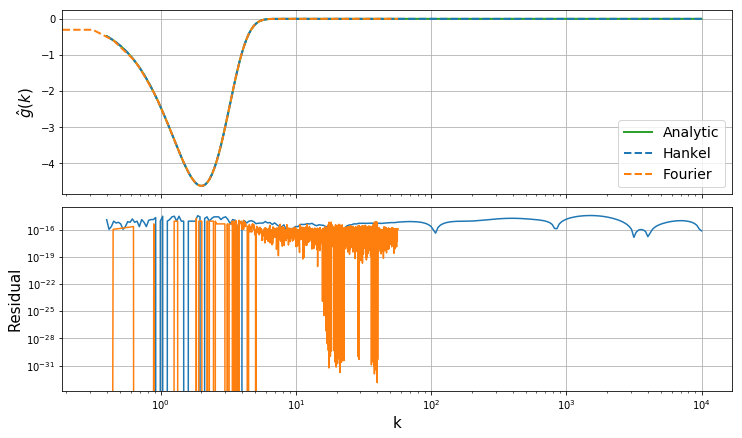

In [46]:
plot_comparison('k', 'ghat', "$\hat{g}(k)$")

### 2. Inverse Transform

#### a. Hankel

In [47]:
# Interpolate onto a spline

spl_inv = spline(H['k'], -H['ghat']/H['k']**2)
H['f'] = ht.transform(spl_inv, H['r'], ret_err=False, inverse=True)

#### b. Fourier

In [48]:
# Differentiate in spectral space

F['fhat'] =  -F['ghat_grid']/ F['kgrid']**2
F['fhat'][np.isnan(F['fhat'])] = np.pi # This is the limiting value at k=0.

F['fgrid'], _, F['r'], F['f'] = ft2d(F['fhat'], 2*L, inverse=True)

/home/steven/miniconda3/envs/hankel/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/steven/miniconda3/envs/hankel/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


#### c. Compare

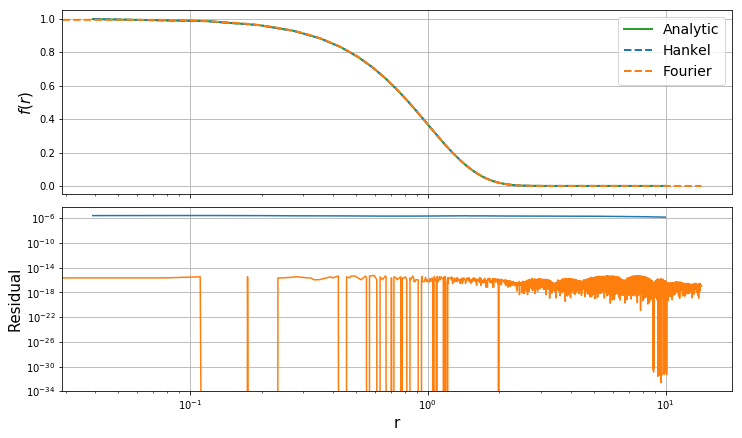

In [49]:
plot_comparison('r', 'f', "$f(r)$")